In [1]:
import tkinter as tk
from tkinter import filedialog
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to parse the input file and extract vehicle capacity and customer data
def parse_input(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    vehicle_capacity = None
    customers = []

    # Extract vehicle capacity by looking for the "CAPACITY" line
    for i, line in enumerate(lines):
        if "CAPACITY" in line:
            # Get the next line for the actual values
            values_line = lines[i + 1].strip().split()
            vehicle_capacity = int(values_line[1])  # Extract the capacity value
            break

    if vehicle_capacity is None:
        raise ValueError("Vehicle capacity not found in the input file.")

    # Locate the start of the customer data
    start_index = None
    for i, line in enumerate(lines):
        if "CUST NO." in line:
            start_index = i + 1  # Data starts immediately after this line
            break

    if start_index is None:
        raise ValueError("Customer data section not found in file.")

    # Parse customer data
    for line in lines[start_index:]:
        data = line.strip().split()
        if len(data) < 7:  # Ignore lines without sufficient data
            continue
        try:
            customer = {
                "id": int(data[0]),
                "x": float(data[1]),
                "y": float(data[2]),
                "demand": int(data[3]),
                "ready_time": int(data[4]),
                "due_date": int(data[5]),
                "service_time": int(data[6])
            }
            customers.append(customer)
        except ValueError:
            # Skip malformed lines
            continue

    return vehicle_capacity, customers

In [3]:
# Function to calculate Euclidean distance between two customers
def euclidean_distance(cust1, cust2):
    return math.sqrt((cust1['x'] - cust2['x'])**2 + (cust1['y'] - cust2['y'])**2)


# Function to calculate travel time (using Euclidean distance as a proxy for time)
def calculate_travel_time(cust1, cust2):
    return euclidean_distance(cust1, cust2)

In [4]:
# Genetic Algorithm helpers
def generate_initial_population(population_size, num_customers):
    population = []
    for _ in range(population_size):
        individual = list(range(num_customers))
        random.shuffle(individual)
        population.append(individual)
    return population

In [5]:
# Function to calculate the depot's position as the center of the customer locations
def calculate_depot_center(customers):
    x_center = sum(cust['x'] for cust in customers) / len(customers)
    y_center = sum(cust['y'] for cust in customers) / len(customers)
    return x_center, y_center

In [6]:
def mutate(individual, mutation_rate):
    if random.random() < mutation_rate:
        # Randomly choose two positions to swap
        pos1, pos2 = random.sample(range(len(individual)), 2)
        individual[pos1], individual[pos2] = individual[pos2], individual[pos1]
    return individual

In [19]:
def fitness(individual, dist_matrix, vehicle_capacity, customers, penalty_time=500):
    total_distance = 0
    total_demand = 0
    num_vehicles = 1
    total_time_penalty = 0
    current_time = 0  # Start time
    
    for i in range(len(individual) - 1):
        current_customer = customers[individual[i]]
        next_customer = customers[individual[i + 1]]
        travel_time = dist_matrix[individual[i]][individual[i + 1]]
        current_time += travel_time
        
        if current_time < next_customer['ready_time']:
            total_time_penalty += (next_customer['ready_time'] - current_time) * penalty_time
        elif current_time > next_customer['due_date']:
            total_time_penalty += (current_time - next_customer['due_date']) * penalty_time

        total_distance += travel_time
        total_demand += current_customer['demand']

        if total_demand > vehicle_capacity:
            num_vehicles += 1
            total_demand = next_customer['demand']

    penalty = (num_vehicles - 1) * 1000
    return total_distance + penalty + total_time_penalty


def crossover(parent1, parent2):
    # Perform crossover between two parents (partially mapped crossover)
    size = len(parent1)
    child = [-1] * size
    crossover_point = random.randint(0, size)

    # Copy part of the first parent to the child
    for i in range(crossover_point):
        child[i] = parent1[i]

    # Fill the remaining part with genes from the second parent
    for i in range(size):
        if child[i] == -1:
            for gene in parent2:
                if gene not in child:
                    child[i] = gene
                    break
    return child


In [20]:
def select_parents(population, dist_matrix, vehicle_capacity, customers):
    # Tournament selection: select the best two individuals
    tournament_size = 5
    selected = random.sample(population, tournament_size)
    selected.sort(key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    return selected[0], selected[1]

In [21]:
# Plotting functions
def plot_routes(customers, routes, depot=(0, 0)):
    plt.figure(figsize=(12, 8))
    plt.plot(depot[0], depot[1], 'ks', label="Depot", markersize=10)
    plt.text(depot[0] + 0.2, depot[1], 'Depot', fontsize=12, ha='left')

    customer_x = [cust['x'] for cust in customers]
    customer_y = [cust['y'] for cust in customers]
    plt.scatter(customer_x, customer_y, c='b', label="Customers", zorder=5)

    for cust in customers:
        plt.text(cust['x'] + 0.2, cust['y'], str(cust['id']), fontsize=9, ha='right')

    for route_idx, route in enumerate(routes):
        route_x = [customers[customer_id]['x'] for customer_id in route]
        route_y = [customers[customer_id]['y'] for customer_id in route]
        route_x = [depot[0]] + route_x + [depot[0]]
        route_y = [depot[1]] + route_y + [depot[1]]
        plt.plot(route_x, route_y, marker='o', linestyle='-', label=f"Route {route_idx + 1}")

    plt.title('Vehicle Routing Problem (VRP) - All Routes', fontsize=16)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_individual_routes(customers, routes, depot=(0, 0)):
    for route_idx, route in enumerate(routes):
        plt.figure(figsize=(8, 6))
        plt.plot(depot[0], depot[1], 'ks', label="Depot", markersize=10)
        plt.text(depot[0] + 0.2, depot[1], 'Depot', fontsize=12, ha='left')

        route_x = [customers[customer_id]['x'] for customer_id in route]
        route_y = [customers[customer_id]['y'] for customer_id in route]
        route_x = [depot[0]] + route_x + [depot[0]]
        route_y = [depot[1]] + route_y + [depot[1]]
        plt.plot(route_x, route_y, marker='o', linestyle='-', label=f"Route {route_idx + 1}")
        plt.scatter([customers[customer_id]['x'] for customer_id in route],
                    [customers[customer_id]['y'] for customer_id in route],
                    c='b', label="Customers")

        for customer_id in route:
            cust = customers[customer_id]
            plt.text(cust['x'] + 0.2, cust['y'], str(cust['id']), fontsize=9, ha='right')

        plt.title(f'Route {route_idx + 1}', fontsize=16)
        plt.xlabel('X Coordinate', fontsize=12)
        plt.ylabel('Y Coordinate', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()

def plot_fitness_evolution(fitness_values):
    plt.figure(figsize=(8, 6))
    plt.plot(fitness_values, color='b', marker='o')
    plt.title('Fitness Evolution Over Generations', fontsize=16)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness Value (Total Distance)', fontsize=12)
    plt.grid(True)
    plt.show()

In [22]:
# Extract routes
def extract_routes(best_individual, customers, vehicle_capacity):
    routes = []
    total_demand = 0
    routes.append([best_individual[0]])

    for i in range(1, len(best_individual)):
        current_customer = customers[best_individual[i - 1]]
        next_customer = customers[best_individual[i]]
        total_demand += current_customer['demand']

        if total_demand > vehicle_capacity:
            routes.append([best_individual[i]])
            total_demand = next_customer['demand']
        else:
            routes[-1].append(best_individual[i])

    return routes

In [23]:
# Replace the fixed depot coordinates with the calculated center
def solve_vrptw_with_centered_depot(file_path):
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate the depot location as the center of customers
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    population_size = 50
    generations = 100
    mutation_rate = 0.01
    population = generate_initial_population(population_size, num_customers)
    
    fitness_history = []
    evolved_vehicles_count = []
    

    for gen in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        population = new_population

        best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
        fitness_history.append(fitness(best_individual, dist_matrix, vehicle_capacity, customers))
        routes = extract_routes(best_individual, customers, vehicle_capacity)
        num_vehicles = len(routes)
        evolved_vehicles_count.append(num_vehicles)
        print(f"Generation {gen + 1}, Best Fitness: {fitness_history[-1]}")

    best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    routes = extract_routes(best_individual, customers, vehicle_capacity)

    # Plot the results with the depot in the center
    plot_fitness_evolution(fitness_history)  # Fitness evolution over generations
    plot_routes(customers, routes, depot=depot)
    plot_individual_routes(customers, routes, depot=depot)



In [24]:

def evaluate_parameter_combinations(file_path):
    # Parse input file and calculate depot location
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate depot location as the center of customer locations
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    # Create distance matrix
    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    # Parameter combinations
    population_sizes = [20, 50, 100]
    generations_list = [50, 100, 200]
    mutation_rates = [0.01, 0.05, 0.1]

    best_combination = None
    best_fitness = float('inf')
    results = []

    # Evaluate all combinations
    for population_size in population_sizes:
        for generations in generations_list:
            for mutation_rate in mutation_rates:
                population = generate_initial_population(population_size, num_customers)

                for gen in range(generations):
                    new_population = []
                    for _ in range(population_size // 2):
                        parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
                        child1 = crossover(parent1, parent2)
                        child2 = crossover(parent2, parent1)
                        new_population.append(mutate(child1, mutation_rate))
                        new_population.append(mutate(child2, mutation_rate))
                    population = new_population

                best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
                best_individual_fitness = fitness(best_individual, dist_matrix, vehicle_capacity, customers)

                # Record the results
                results.append({
                    'population_size': population_size,
                    'generations': generations,
                    'mutation_rate': mutation_rate,
                    'fitness': best_individual_fitness
                })

                print(f"Pop: {population_size}, Gen: {generations}, Mut: {mutation_rate} => Fitness: {best_individual_fitness}")

                # Update the best combination
                if best_individual_fitness < best_fitness:
                    best_fitness = best_individual_fitness
                    best_combination = {
                        'population_size': population_size,
                        'generations': generations,
                        'mutation_rate': mutation_rate
                    }

    print("\nBest Parameter Combination:")
    print(f"Population Size: {best_combination['population_size']}, "
          f"Generations: {best_combination['generations']}, "
          f"Mutation Rate: {best_combination['mutation_rate']}, "
          f"Fitness: {best_fitness}")

    # Plot results
    fitness_scores = [result['fitness'] for result in results]
    combinations = [f"Pop: {res['population_size']}, Gen: {res['generations']}, Mut: {res['mutation_rate']}" for res in results]

    plt.figure(figsize=(10, 6))
    plt.bar(combinations, fitness_scores, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Fitness Scores for Parameter Combinations', fontsize=16)
    plt.xlabel('Parameter Combinations', fontsize=12)
    plt.ylabel('Fitness Score', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Generation 1, Best Fitness: 90431146.2434964
Generation 2, Best Fitness: 89694675.32780267
Generation 3, Best Fitness: 85840626.89703962
Generation 4, Best Fitness: 85605838.07194357
Generation 5, Best Fitness: 83460293.4003888
Generation 6, Best Fitness: 81356473.92379084
Generation 7, Best Fitness: 83106034.33589092
Generation 8, Best Fitness: 81900635.66419166
Generation 9, Best Fitness: 81021667.50968362
Generation 10, Best Fitness: 81021667.50968362
Generation 11, Best Fitness: 79281498.54966761
Generation 12, Best Fitness: 79128001.09607841
Generation 13, Best Fitness: 77743429.40856816
Generation 14, Best Fitness: 77743429.40856816
Generation 15, Best Fitness: 77743429.40856816
Generation 16, Best Fitness: 76974965.39874989
Generation 17, Best Fitness: 76430424.33054443
Generation 18, Best Fitness: 76430424.33054443
Generation 19, Best Fitness: 76131390.52681804
Generation 20, Best Fitness: 76131390.52681804
Generation 21, Best Fitness: 76113358.15335266
Generation 22, Best Fitn

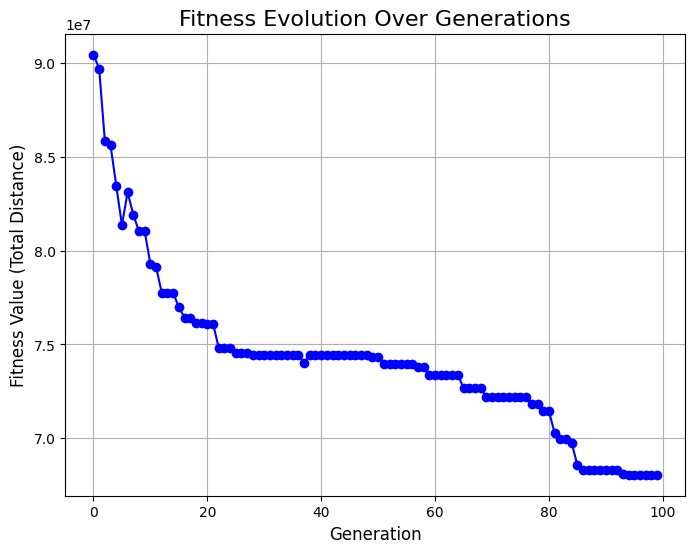

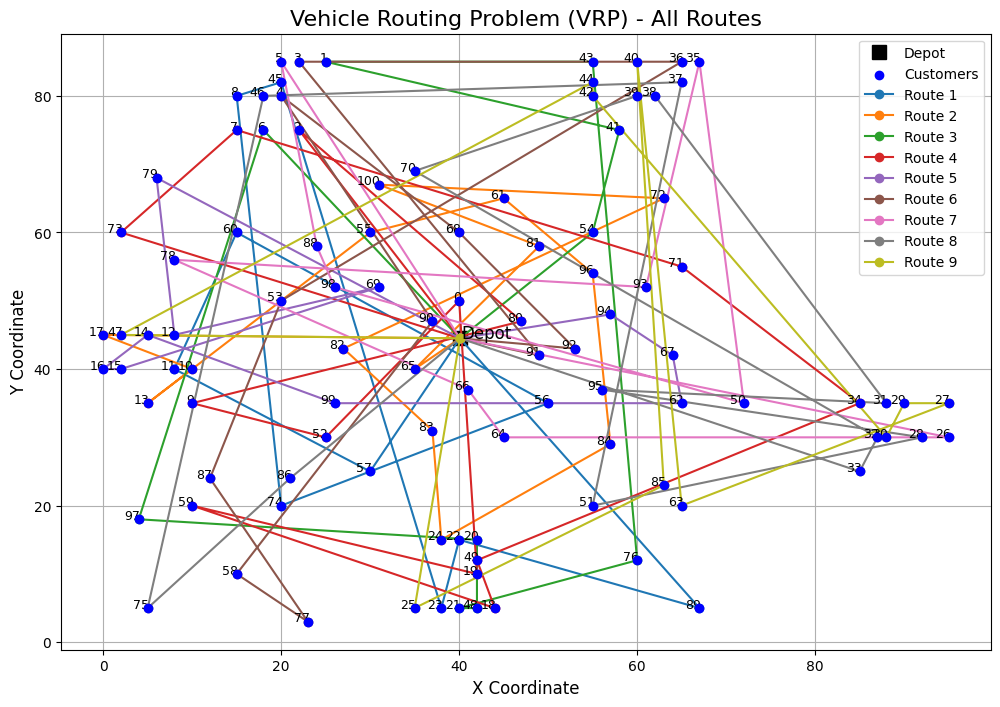

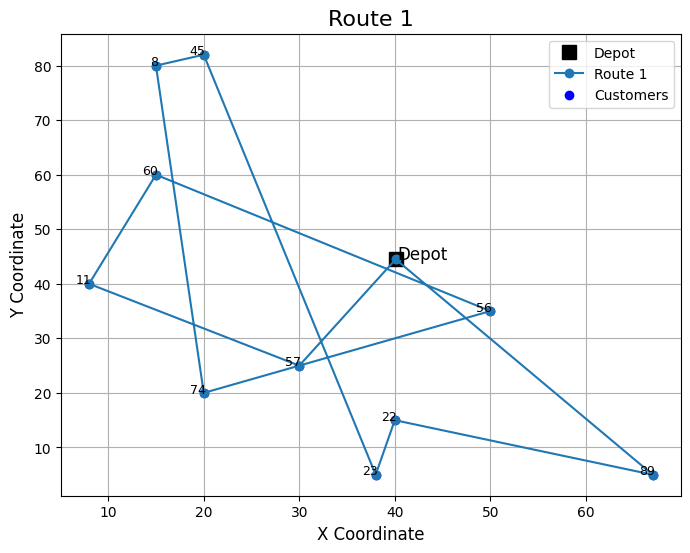

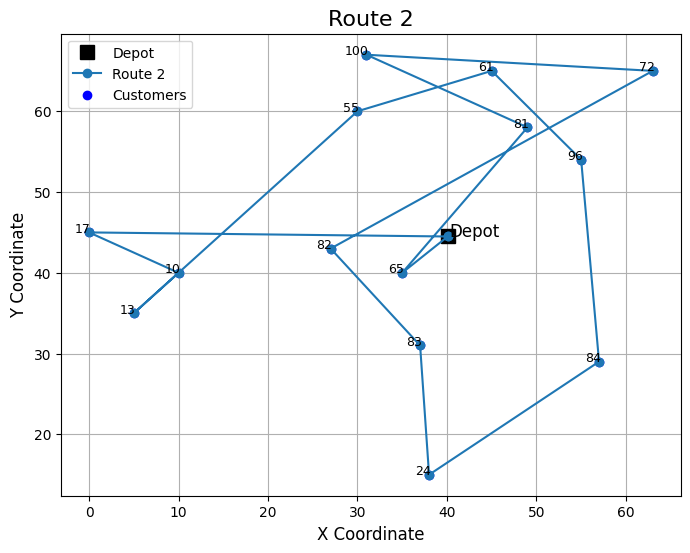

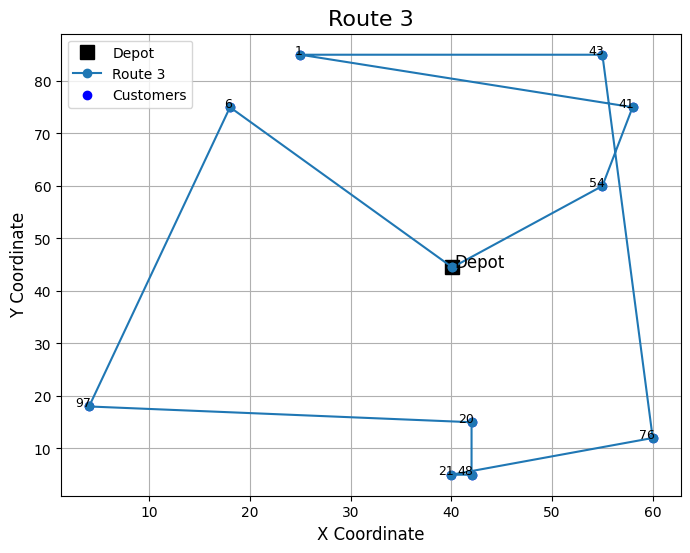

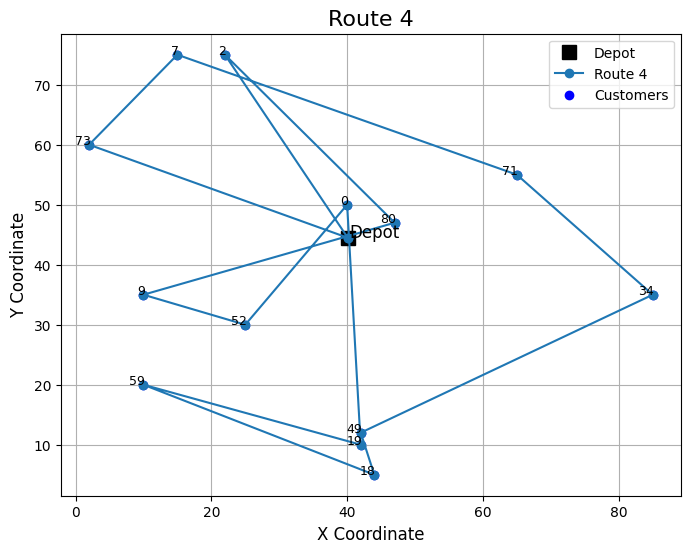

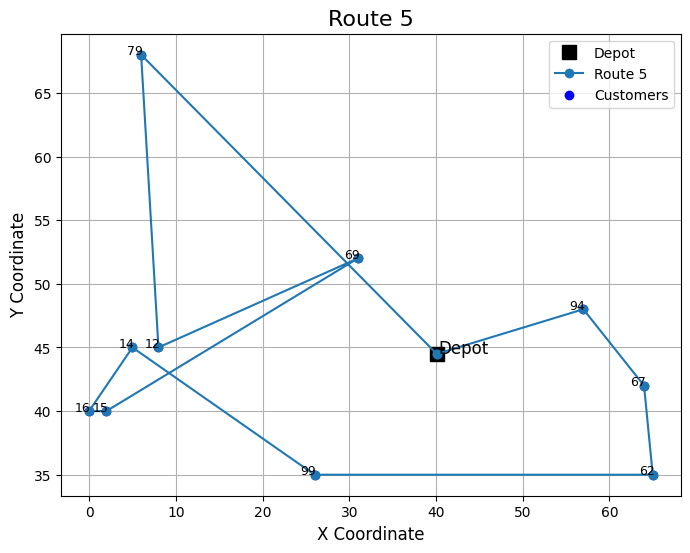

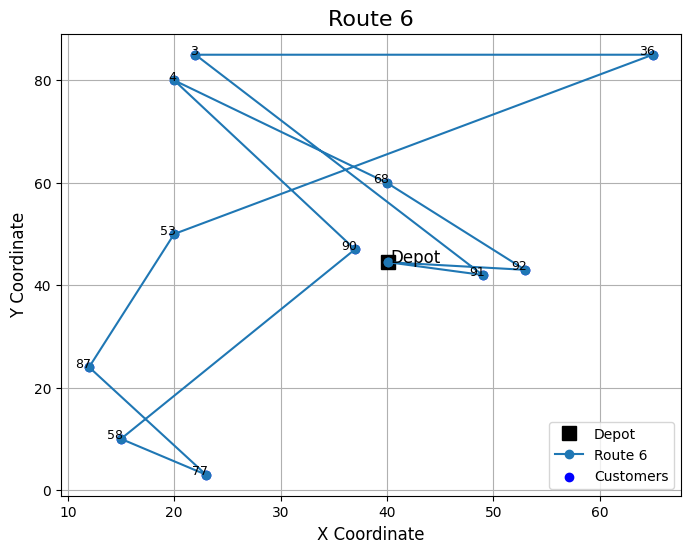

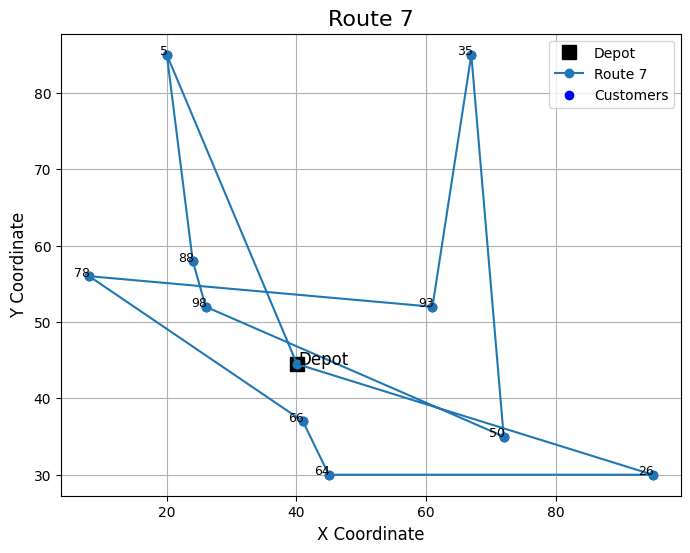

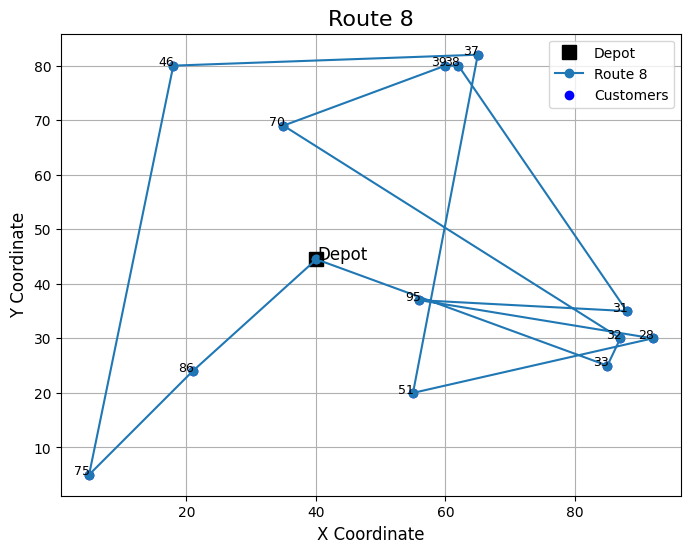

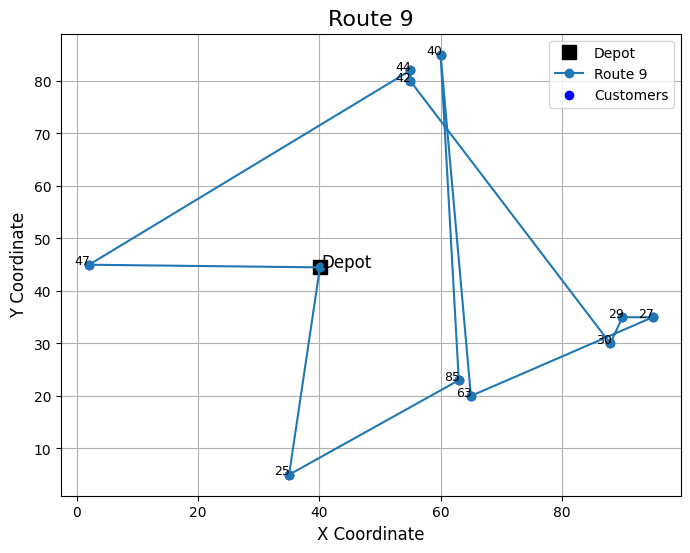

Pop: 20, Gen: 50, Mut: 0.01 => Fitness: 80803232.3078179
Pop: 20, Gen: 50, Mut: 0.05 => Fitness: 77268422.87968484
Pop: 20, Gen: 50, Mut: 0.1 => Fitness: 72268827.11520182
Pop: 20, Gen: 100, Mut: 0.01 => Fitness: 78124052.60837734
Pop: 20, Gen: 100, Mut: 0.05 => Fitness: 77311538.9575743
Pop: 20, Gen: 100, Mut: 0.1 => Fitness: 60133140.630951606
Pop: 20, Gen: 200, Mut: 0.01 => Fitness: 77421441.25942184
Pop: 20, Gen: 200, Mut: 0.05 => Fitness: 52695776.238916434
Pop: 20, Gen: 200, Mut: 0.1 => Fitness: 57608764.54043284
Pop: 50, Gen: 50, Mut: 0.01 => Fitness: 84457586.79625444
Pop: 50, Gen: 50, Mut: 0.05 => Fitness: 63182358.55128761
Pop: 50, Gen: 50, Mut: 0.1 => Fitness: 59307485.386887774
Pop: 50, Gen: 100, Mut: 0.01 => Fitness: 71503605.34050052
Pop: 50, Gen: 100, Mut: 0.05 => Fitness: 62498350.10076843
Pop: 50, Gen: 100, Mut: 0.1 => Fitness: 55629237.552124284
Pop: 50, Gen: 200, Mut: 0.01 => Fitness: 63661966.64855872
Pop: 50, Gen: 200, Mut: 0.05 => Fitness: 47322047.56633893
Pop: 5

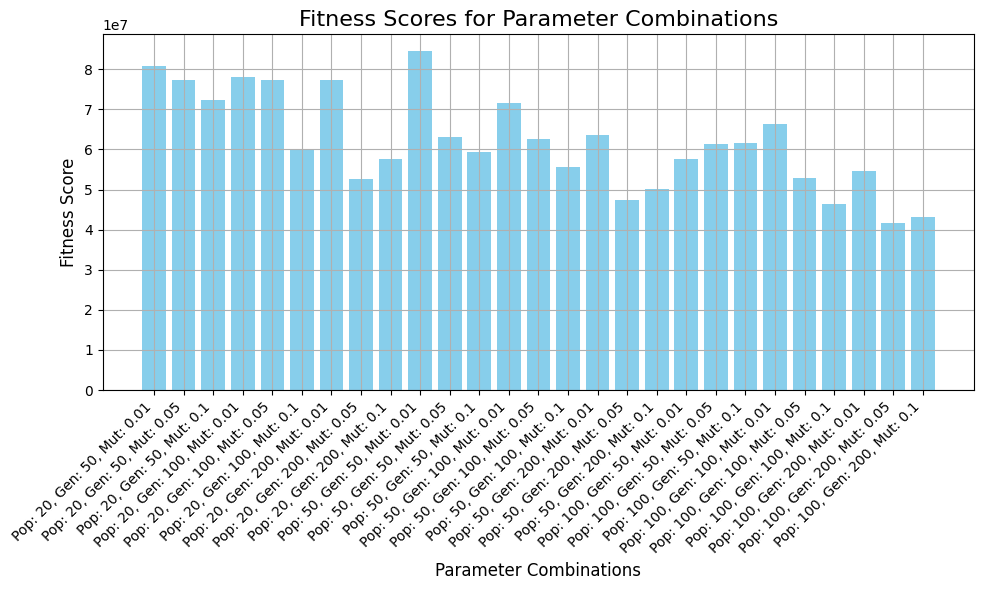

In [25]:
if __name__ == "__main__":
    root = tk.Tk()
    root.withdraw()
    file_path = "rc1/rc101.txt"
    if file_path:
        solve_vrptw_with_centered_depot(file_path)
        evaluate_parameter_combinations(file_path)